### 🧩 Anomaly Detection in the News Feed

This analysis focuses on identifying unusual user activity patterns in a mobile application that provides a **personalized news feed**.  
Users can browse posts, like them, and interact with the content that matches their interests.  

During routine monitoring, a **sudden drop in Daily Active Users (DAU)** was detected on **August 24, 2025**.  
The objective of this study is to locate the cause of this anomaly and understand whether it was a technical issue, a localized outage, or a behavioral shift in user engagement.  

To achieve this, we analyze user activity across countries, cities, and segments to determine where and why the drop occurred.

---

**Context**

The dataset contains user activity logs from August 22 to August 26, 2025.  
We analyze the dynamics of user engagement across the top 7 countries and further examine Russian cities to identify regional irregularities.

---

**Goals**

- Detect anomalies in user activity across countries and cities;  
- Determine whether the observed drop was isolated or systemic;  
- Assess potential factors influencing the anomaly (e.g., geography, gender, OS).  

---

**Expected Outcome**

Identify whether the detected drop in DAU on **August 24, 2025** was due to:

- data upload or logging errors;  
- a regional outage affecting specific cities; 
- a genuine change in user behavior.


In [1]:
#importing libraries
import pandahouse as ph
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#database connection parameters (ClickHouse)
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
#count DAU (top 7 countries)
query = """
with top_countries as (
    select country
    from simulator_20250820.feed_actions
    group by country
    order by countDistinct(user_id) desc
    limit 7
)

select
    toDate(time) as date,
    case 
        when country in (
        select country 
        from top_countries
        ) 
        then country
        else 'Other'
    end as country_group,
    countDistinct(user_id) as dau
from simulator_20250820.feed_actions
where toDate(time) between '2025-08-22' and '2025-08-26'
group by date, country_group
order by date, dau desc;
"""

In [12]:
#test query
df = ph.read_clickhouse(query, connection=connection)

In [5]:
#create a pivot table for the top 7 countries
df_pivot = df.pivot(index="date", columns="country_group", values="dau")
df_pivot = df_pivot[df_pivot.sum().sort_values(ascending=False).index]

In [6]:
#check
df_pivot

country_group,Russia,Ukraine,Belarus,Kazakhstan,Finland,Azerbaijan,Turkey,Other
date,,,,,,,,
2025-08-22,14588,865,350,334,180,153,152,83
2025-08-23,14216,776,368,305,163,147,149,71
2025-08-24,11908,906,326,362,155,167,180,69
2025-08-25,15316,862,366,353,189,191,170,63
2025-08-26,15477,887,370,350,185,186,161,87


There was a noticeable decline in user activity in Russia on August 24, 2025, compared to the previous day.

For users from other countries, the changes were minor, showing mixed dynamics.
In Ukraine, Kazakhstan, Azerbaijan, and Turkey, the number of users on August 24, 2025 was higher than on August 23, 2025.
Meanwhile, a negative trend was observed in Belarus and Finland, where the number of users decreased by 42 and 8, respectively.

Next, let’s plot a bar chart to visualize the decline in user activity.

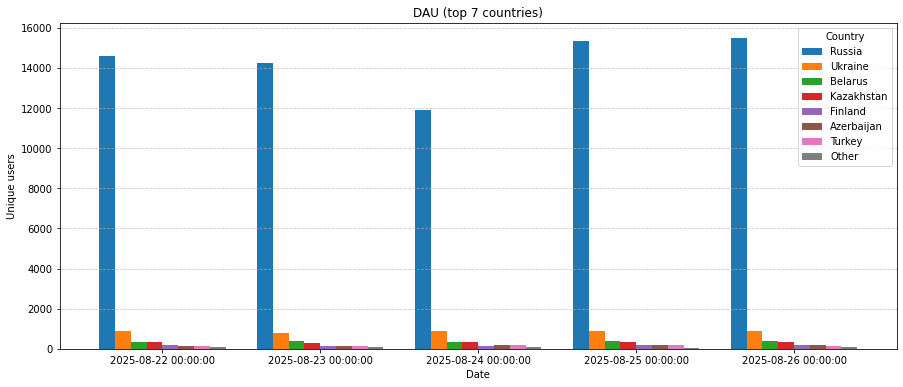

In [14]:
#plot a bar chart for the top 7 countries using the news feed
ax = df_pivot.plot(kind="bar", figsize=(15,6), width=0.8)
plt.title("DAU (top 7 countries)")
plt.xlabel("Date")
plt.ylabel("Unique users")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Country")
plt.show()

The provided logs also contain data on user activity broken down by cities.

Let’s take a closer look at Russian cities for the same time period.

In [15]:
#since there are too many cities, filter only those with DAU greater than 150
query_1="""
select 
    toDate(time) as date,
    country,
    city,
    countDistinct(user_id) as dau
from simulator_20250820.feed_actions
where toDate(time) between '2025-08-22' and '2025-08-26' 
  and country = 'Russia'
  group by date, country, city
  having countDistinct(user_id) >=150
order by date
"""

In [16]:
#test query
df_2 = ph.read_clickhouse(query_1, connection=connection)

In [10]:
#create a pivot table for Russian cities
df_pivot_2 = df_2.pivot(index="date", columns="city", values="dau")

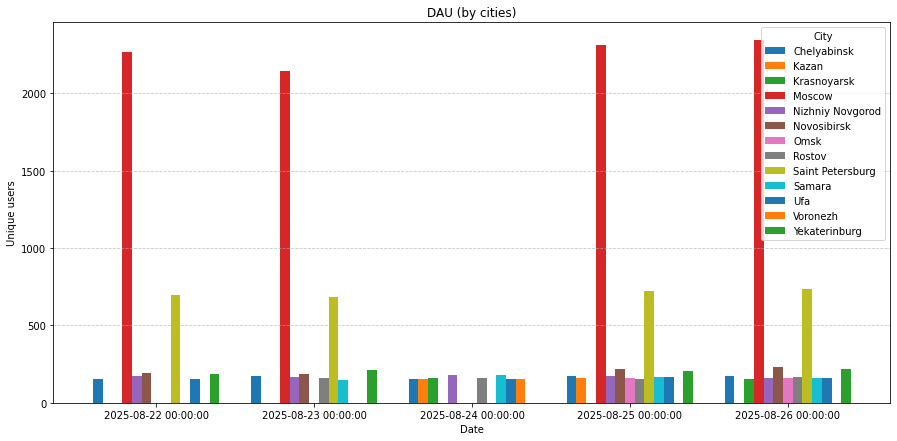

In [17]:
#plot a bar chart for the cities using the news feed
ax = df_pivot_2.plot(kind="bar", figsize=(15,7), width=0.8)
plt.title("DAU (by cities)")
plt.xlabel("Date")
plt.ylabel("Unique users")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="City", loc="upper right")
plt.show()

The obtained DAU by Russian cities confirms the issue in user activity on August 24, 2025.
On that day, data for Moscow and Saint Petersburg is missing from the dataset, even though these cities consistently ranked among the top by the number of active users on other dates.
As a result, the total number of active users in Russia dropped sharply.

Additionally, using **Redash**, the following checks were performed:

- User activity was analyzed by gender and operating system — no anomalies were found;
- User activity was reviewed for all Russian cities whose residents used the app on August 23, 2025, but not on August 24, 2025, excluding Moscow and Saint Petersburg. Again, no anomalies were detected. A total of 29 users who were active in the news feed on August 23, 2025 did not log in on August 24, 2025. These appear to be regular users who simply skipped one day of activity (≈1 user per city), which does not indicate any systemic failures or widespread access issues with the news feed.

# Conclusion

Based on the results of the analysis, we can draw the following conclusions:

- First, we compared user activity by country, which helped to determine that the issue was localized only in Russia;
- Second, we analyzed user activity by city, which revealed key behavioral patterns among users.

Thus, the issue appears to be related not to individual users, but to a specific group — namely, residents of Russia’s largest cities.

Users are united by geography: those in Moscow and Saint Petersburg were unable to access the news feed on August 24, 2025, indicating a technical failure or localized service outage.
It is also possible that the issue stems from data logging or upload errors in the database.

**Recommendations:**

- Verify with the data engineering team whether user session data for August 24, 2025 was correctly uploaded;
- Confirm with the infrastructure team whether any maintenance or technical work was carried out on that date.